# 장기기억을 할 수 있는 버전 RNN

# 패키지 로딩

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 하이퍼 파라미터 설정

In [25]:
TRAIN_SPLIT = 300000
EVALUATION_INTERVAL = 200
EPOCH = 10
tf.random.set_seed(13)

# 데이터 로딩 및 확인
- 2009년 이후 10분 간격으로 관측된 온도, 대기압, 습도와 같은 14종류의 관측치를 포함한 날씨 데이터셋
- 한 시간동안 6개, 하루에 144개의 관측치를 포함

In [26]:
df = pd.read_csv('jena_climate_2009_2016.csv')
print(df.shape)
display(df.head())

(420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [27]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB
None


# 분석 데이터 컬럼 추출
- 14개의 특성값 중 3개(기압, 기온, 공기밀도)만 특성값으로 추출

In [28]:
columns = ['p (mbar)', 'T (degC)','rho (g/m**3)']
features = df[columns]
features.index = df['Date Time']
display(features.head())

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


# 학습데이터 분리 및 표준화

In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
# 표준화 식  현재 데이터 - 평균 / 표준편차
dataset = (dataset - data_mean) / data_std

print(dataset.shape)
print(dataset)

(420551, 3)
[[ 0.95547359 -1.99766294  2.2350791 ]
 [ 0.96154485 -2.04281897  2.28524007]
 [ 0.95668784 -2.05439744  2.29600633]
 ...
 [ 1.35617678 -1.43494935  1.76136375]
 [ 1.35496252 -1.55883897  1.88786728]
 [ 1.35617678 -1.62715193  1.95686921]]


# 타임스텝 별 데이터 분리 함수 정의
- 매개변수 설명
>- dataset : 학습데이터 셋
>- target : 종속변수
>- start_index : dataset의 시작 인덱스
>- end_index : dataset의 끝 인덱스
>- history size : 과거데이터의 크기 ex.720 지난 5일간의 데이터 하루에 144개 생성되니까
>- target_size : 예측해야할 레이블의 크기 ex. 얼마동안의 미래를 예측할지 ex.72는 12시간 이후 온도 예측 6*12시간
>- step : 샘플링 간격 (6 -> 1시간 단위로 샘플링, 60분 내에 기온의 급격한 변화가 예상되지 않으므로 샘플링을 1시간 단위로 수행)
>- single_step : 주어진 과거의 자료로부터 하나의 포인트를 예측할지 결정

In [40]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False) : 
    data = [] #독립변수 저장
    labels = [] # 종속변수 저장
    start_index = start_index + history_size
    if end_index is None : # 검증데이터를 분할 할때 end_index를 none으로 지정 (데이터셋 끝까지 추출하겠다는 의미)
        end_index = len(dataset) - target_size # ex. start_index = 0, history size = 720
    for i in range (start_index, end_index) : #(720, 300000)
        indexes = range (i - history_size, i, step) #1st data indexes : range (720-720, 720, 6)
        data.append(dataset[indexes])
        if single_step:
            labels.append(target[i+target_size]) # target[720:720+72] -> 12시간 후 의 기온예측
        else : # 미래의 연속된 구간의 기온예측
            labels.append(target[i:i+target_size]) #> 12시간 동안의 기온예측
    return np.array(data), np.array(labels)

# 싱글스텝예측
- 주어진 과거의 자료로부터 미래의 단일 지점을 예측

In [41]:
past_history = 720 # 지난 5일간의 데이터
future_target = 72 # 12시간이후 온도 예측
STEP = 6 # 샘플링 간격을 1시간 단위로 추출

x_train_single, y_train_single = multivariate_data(dataset, target=dataset[:,1], start_index=0, end_index=TRAIN_SPLIT, history_size = past_history, target_size=future_target, step=STEP, single_step = True)

x_val_single, y_val_single = multivariate_data(dataset, target=dataset[:,1], start_index=TRAIN_SPLIT, end_index=None, history_size = past_history,target_size=future_target, step=STEP, single_step = True)


In [42]:
# 타입 스텝별로 분할된 데이터 셋 개수 : 299280
# 120 : 5일간의 과거 데이터 (720개의 과거 데이터를 6단계로 추출해서 120개의 데이터로 구성)
# 3 : 3개의 특성
print(x_train_single.shape)
print(y_train_single.shape)

(299280, 120, 3)
(299280,)


# 학습 및 평가 데이터 추출

## [참고] from_tensor_slices()함수의 이해
- tf.data는 데이터 입력 파이프 라인 빌드를 위한 텐서플로우 서브패키지임. 로컬 파일이나 메모리에 올려져 있는 데이터를 모델에 집어넣기 적합한 텐서로 변환하는 작업을 한다.
- from_tensor_slices ( )는 주어진 텐서들의 첫번째 차원을 따라 슬라이스 한다.

In [49]:
x_train = [[[1],[2]],
           [[3],[4]],
           [[5],[6]]]
y_train = [0.1, 0.2, 0.3]
print(np.array(x_train).shape)
data = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(2,drop_remainder=True)
print(data)
print()
print(list(data))

(3, 2, 1)
<_BatchDataset element_spec=(TensorSpec(shape=(2, 2, 1), dtype=tf.int32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

[(<tf.Tensor: shape=(2, 2, 1), dtype=int32, numpy=
array([[[1],
        [2]],

       [[3],
        [4]]])>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.2], dtype=float32)>)]


- cache : 데이터셋을 캐시 메모리나 파일에 보관한다. 따라서 두번째 데이터 추출부터는 캐시된 데이터를 사용한다.
- shuffle : 데이터셋을 임의로 섞어준다. buffersize개로 이루어진 버퍼로부터 임의의 샘플을 뽑고 뽀은 샘플은 다른 샘플로 대체한다
- batch : 데이터셋을 하나의 배치로 묶어준다. 만약 배치개수가 맞지 않는 마지막 배치를 생성하지 않기 위해서는 drop_remainder=True 옵션을 지정한다.
- repeat (n) : 데이터셋을 n번만큼 반복해서 생성한다. 만약 반복횟수가 생략되면 데이터셋이 무한 반복된다.

In [43]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single,y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single,y_val_single))
val_data_single = val_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True).repeat()

In [50]:
print(train_data_single)

<_RepeatDataset element_spec=(TensorSpec(shape=(256, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None))>


In [52]:
next(iter(train_data_single))[0].shape

TensorShape([256, 120, 3])

In [ ]:
next(iter(train_data_single))[1].shape

# LSTM 모델 구축 및 학습

In [57]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:])) # tensor shape : [256,120,3]
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mae')

single_step_history = single_step_model.fit(train_data_single,epochs=EPOCH,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_single, validation_steps=50)

Epoch 1/10

200/200 [==============================] - 24s 103ms/step - loss: 0.3174 - val_loss: 0.2766
Epoch 2/10
200/200 [==============================] - 20s 99ms/step - loss: 0.2616 - val_loss: 0.2478
Epoch 3/10
200/200 [==============================] - 20s 101ms/step - loss: 0.2604 - val_loss: 0.2678
Epoch 4/10
200/200 [==============================] - 20s 101ms/step - loss: 0.2581 - val_loss: 0.2497
Epoch 5/10
200/200 [==============================] - 21s 104ms/step - loss: 0.2285 - val_loss: 0.2474
Epoch 6/10
200/200 [==============================] - 22s 111ms/step - loss: 0.2413 - val_loss: 0.2678
Epoch 7/10
200/200 [==============================] - 22s 109ms/step - loss: 0.2444 - val_loss: 0.2774
Epoch 8/10
200/200 [==============================] - 20s 99ms/step - loss: 0.2421 - val_loss: 0.2657
Epoch 9/10
200/200 [==============================] - 19s 96ms/step - loss: 0.2454 - val_loss: 0.2610
Epoch 10/10
200/200 [==============================] - 19s 97ms/step - loss

# 손실 변화 시각화 함수 정의

In [59]:
def plot_train_history (history,title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch = range(len(loss))
    plt.plot(epoch,loss,'b',label='Training loss')
    plt.plot(epoch, val_loss,'r', label='validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

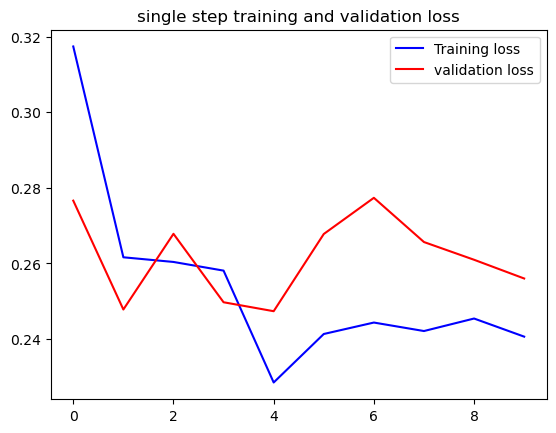

In [61]:
plot_train_history(single_step_history,'single step training and validation loss')

# 예측결과 시각화 함수

In [62]:
# 그래프의 x축 좌표 값 생성
def create_time_steps(length):
    return list(range(-length, 0))

# plot_data: [5일간 기온 데이터, 12시간 후 기온 데이터, 예측 값]
# delta: 미래 예측 지점
# title: 그래프 제목
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

8/8 [==============================] - 0s 15ms/step


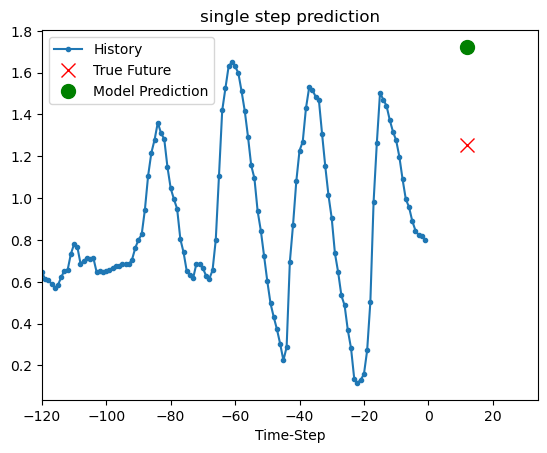

8/8 [==============================] - 0s 16ms/step


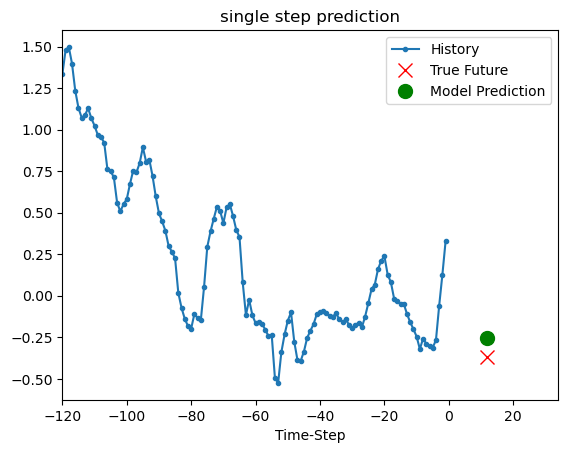

8/8 [==============================] - 0s 12ms/step


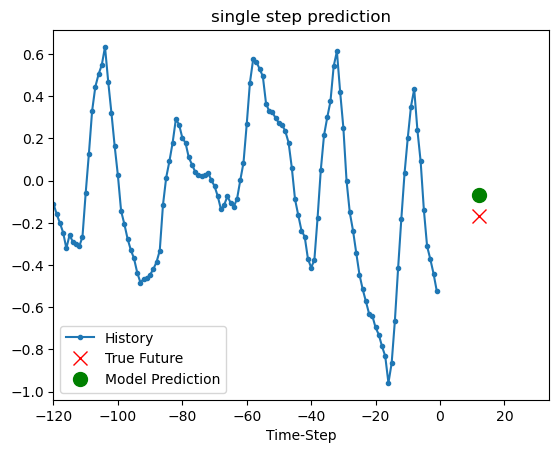

In [71]:
for x, y in val_data_single.take(3) :
    plot = show_plot([x[0][:,1].numpy(), y[0].numpy(), single_step_model.predict(x)[0]], 12, 'single step prediction')
    plt.show()

# 멀티스텝예측
- 과거 히스토리가 주어지면 미래의 값 범위를 예측
- 멀티 스텝은 미래의 시퀀스를 예측한다.

## 타입 스텝별 독립변수와 종속변수 추출

In [72]:
past_history = 720 # 지난 5일간의 데이터
future_target = 72 # 12시간이후 온도 예측
STEP = 6 # 샘플링 간격을 1시간 단위로 추출

x_train_multi, y_train_multi = multivariate_data(dataset, target=dataset[:,1], start_index=0, end_index=TRAIN_SPLIT, history_size = past_history, target_size=future_target, step=STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, target=dataset[:,1], start_index=TRAIN_SPLIT, end_index=None, history_size = past_history,target_size=future_target, step=STEP)

## 학습 및 평가 데이터 추출

In [82]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi,y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi,y_val_multi))
val_data_multi = val_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True).repeat()

In [83]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_single.shape[-2:])) # tensor shape : [256,120,3] 싱글스텝예측보다 복잡하기 때문에 lstm을 두개의 층으로 구성
multi_step_model.add(tf.keras.layers.LSTM(16,activation='relu'))
# 미래 12시간동안의 온도를 예측해야 해서 출력값의 크기를 72로 설정
multi_step_model.add(tf.keras.layers.Dense(72))
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi,epochs=EPOCH,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 55s 252ms/step - loss: 0.6403 - val_loss: 0.2980
Epoch 2/10
200/200 [==============================] - 50s 248ms/step - loss: 0.3326 - val_loss: 0.2694
Epoch 3/10
200/200 [==============================] - 50s 250ms/step - loss: 0.3053 - val_loss: 0.2512
Epoch 4/10
200/200 [==============================] - 50s 249ms/step - loss: 0.2425 - val_loss: 0.2042
Epoch 5/10
200/200 [==============================] - 52s 262ms/step - loss: 0.1982 - val_loss: 0.1971
Epoch 6/10
200/200 [==============================] - 55s 276ms/step - loss: 0.2069 - val_loss: 0.2106
Epoch 7/10
200/200 [==============================] - 56s 279ms/step - loss: 0.2014 - val_loss: 0.2002
Epoch 8/10
200/200 [==============================] - 54s 270ms/step - loss: 0.1976 - val_loss: 0.1915
Epoch 9/10
200/200 [==============================] - 56s 278ms/step - loss: 0.1993 - val_loss: 0.1903
Epoch 10/10
200/200 [==============================] - 54s 273ms/step - l

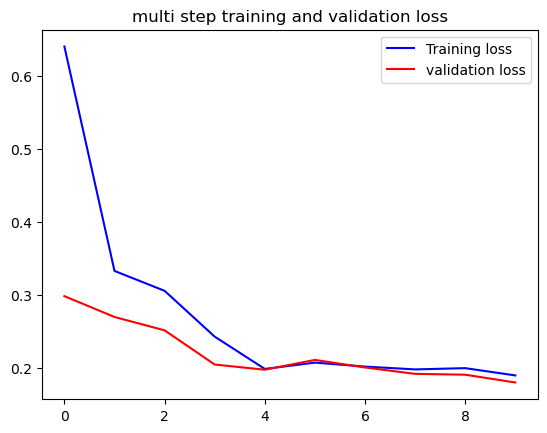

In [84]:
plot_train_history (multi_step_history, 'multi step training and validation loss')

## 예측결과 시각화 함수

In [85]:
# 그래프의 x축 좌표 값 생성
def create_time_steps(length):
    return list(range(-length, 0))

# plot_data: [5일간 기온 데이터, 12시간 후 기온 데이터, 예측 값]
# delta: 미래 예측 지점
# title: 그래프 제목
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    # history[:, 1] : 3개의 독립변 수 중 2번째 컬럼이 기온 데이터
    plt.plot(num_in, np.array(history[:,1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any(): # 값이 있으면...
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend()
    plt.show()

In [86]:
for x, y in val_data_multi.take(3)
    multi_step_plot(x[0],y[0],multi_step_model.predict(x)[0])

SyntaxError: expected ':' (2391895620.py, line 1)